# ML - Fall 2023 - Practical 5

## Decision Trees

Student Name: Ali Aghayari

Student Number: 400104715

In [1]:
! pip install optuna
! pip install catboost
! pip install gdown

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import make_scorer, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [3]:
!gdown 'https://drive.google.com/uc?id=1bhS_RnzzU-NgW8Hgc_03Tl4EOlK-8cJr'

Downloading...
From: https://drive.google.com/uc?id=1bhS_RnzzU-NgW8Hgc_03Tl4EOlK-8cJr
To: /kaggle/working/train.csv
100%|████████████████████████████████████████| 170k/170k [00:00<00:00, 85.3MB/s]


# P1: Explore (13 points)

Load the dataset as a dataframe 

In [4]:
DF = pd.read_csv('train.csv') # changed it to DF 

Inspect the first rows of the dataframe **(P1-1: 1 point)**

In [5]:
DF.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,29,No,Travel_Rarely,592,Research & Development,7,3,Life Sciences,1,1883,...,2,80,0,11,2,3,3,2,1,2
1,36,No,Travel_Rarely,884,Sales,1,4,Life Sciences,1,1585,...,1,80,0,15,5,3,1,0,0,0
2,34,No,Travel_Rarely,1326,Sales,3,3,Other,1,1478,...,4,80,0,15,2,3,13,9,3,12
3,27,No,Travel_Rarely,954,Sales,9,3,Marketing,1,1965,...,1,80,0,7,5,3,7,7,0,7
4,32,No,Travel_Rarely,929,Sales,10,3,Marketing,1,722,...,4,80,0,10,2,2,10,7,0,8


Calculate the number of samples **(P1-2: 0.5 point)**

In [6]:
print("rows : " ,DF.shape[0])
print("cols : " ,DF.shape[1])

rows :  1102
cols :  35


Measure the number of unique values for each column. Note that `Attrition` is the target column. **(P1-3: 1.5 points)**

In [7]:
unique_ = dict()

for i in DF.columns : 
    if i == "Attrition" : continue
    unique_[i] = DF[i].nunique()

for item,value in unique_.items():
    print(item , " : ",value)

Age  :  43
BusinessTravel  :  3
DailyRate  :  736
Department  :  3
DistanceFromHome  :  29
Education  :  5
EducationField  :  6
EmployeeCount  :  1
EmployeeNumber  :  1102
EnvironmentSatisfaction  :  4
Gender  :  2
HourlyRate  :  71
JobInvolvement  :  4
JobLevel  :  5
JobRole  :  9
JobSatisfaction  :  4
MaritalStatus  :  3
MonthlyIncome  :  1027
MonthlyRate  :  1082
NumCompaniesWorked  :  10
Over18  :  1
OverTime  :  2
PercentSalaryHike  :  15
PerformanceRating  :  2
RelationshipSatisfaction  :  4
StandardHours  :  1
StockOptionLevel  :  4
TotalWorkingYears  :  40
TrainingTimesLastYear  :  7
WorkLifeBalance  :  4
YearsAtCompany  :  34
YearsInCurrentRole  :  19
YearsSinceLastPromotion  :  16
YearsWithCurrManager  :  17


Check if there is a column with less than two unique values. If such a columns exists, remove it! **(P1-4: 1.5 points)**

In [8]:
removable_cols = []

for item,value in unique_.items():
    if item not in DF.columns : continue
    if value >=  2: continue
    if item == "Attrition" : continue
    removable_cols.append(item)
    
DF.drop(columns = removable_cols ,inplace = True)
DF.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,29,No,Travel_Rarely,592,Research & Development,7,3,Life Sciences,1883,4,...,3,2,0,11,2,3,3,2,1,2
1,36,No,Travel_Rarely,884,Sales,1,4,Life Sciences,1585,2,...,3,1,0,15,5,3,1,0,0,0
2,34,No,Travel_Rarely,1326,Sales,3,3,Other,1478,4,...,3,4,0,15,2,3,13,9,3,12
3,27,No,Travel_Rarely,954,Sales,9,3,Marketing,1965,4,...,3,1,0,7,5,3,7,7,0,7
4,32,No,Travel_Rarely,929,Sales,10,3,Marketing,722,4,...,3,4,0,10,2,2,10,7,0,8


Plot Mean `BusinessTravel` against `Age`. Note: Since the `BusinessTravel` column is categorical, you should first consider another column corresponding to each unique value `BusinessTravel` takes. For instance, you may assume that if someone does not travel, the value of the column for this person is 0. **(P1-5: 2.5 points)**

In [9]:
print(DF["BusinessTravel"].unique())

"""
# this commented code plots each value individually

dummies = pd.get_dummies(DF['BusinessTravel'])
dummies
"""

['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']


"\n# this commented code plots each value individually\n\ndummies = pd.get_dummies(DF['BusinessTravel'])\ndummies\n"

In [10]:
DF["EBusinessTravel"] = DF["BusinessTravel"].map({"Travel_Frequently" : 2,"Travel_Rarely" : 1,"Non-Travel" :0})

"""
dummies_DF = pd.concat([DF, dummies], axis=1)
dummies_DF['Non-Travel'].fillna(0, inplace=True)
dummies_DF
"""

"\ndummies_DF = pd.concat([DF, dummies], axis=1)\ndummies_DF['Non-Travel'].fillna(0, inplace=True)\ndummies_DF\n"

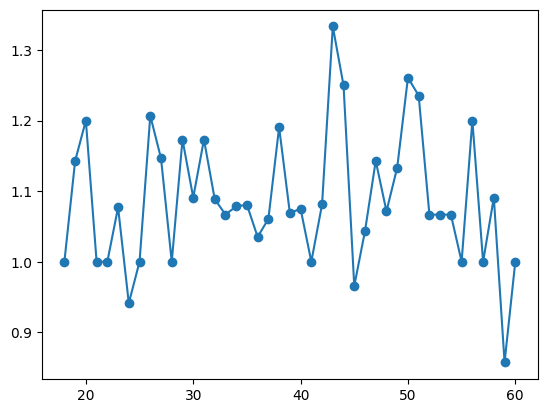

"\nMnon_travel = dummies_DF.groupby('Age')['Non-Travel'].mean()\nMtravel_rarely = dummies_DF.groupby('Age')['Travel_Rarely'].mean()\nMtravel_frequently = dummies_DF.groupby('Age')['Travel_Frequently'].mean()\n\nplt.plot(Mnon_travel.index, Mnon_travel.values, marker='o', label='Non-Travel')\nplt.plot(Mtravel_rarely.index, Mtravel_rarely.values, marker='o', label='Travel_Rarely')\nplt.plot(Mtravel_frequently.index, Mtravel_frequently.values, marker='o', label='Travel_Frequently')\n\nplt.legend()\nplt.show()\n\n"

In [11]:
mean_ = DF.groupby('Age')['EBusinessTravel'].mean().reset_index()
plt.plot(mean_['Age'], mean_['EBusinessTravel'], marker='o')
plt.show()


"""
Mnon_travel = dummies_DF.groupby('Age')['Non-Travel'].mean()
Mtravel_rarely = dummies_DF.groupby('Age')['Travel_Rarely'].mean()
Mtravel_frequently = dummies_DF.groupby('Age')['Travel_Frequently'].mean()

plt.plot(Mnon_travel.index, Mnon_travel.values, marker='o', label='Non-Travel')
plt.plot(Mtravel_rarely.index, Mtravel_rarely.values, marker='o', label='Travel_Rarely')
plt.plot(Mtravel_frequently.index, Mtravel_frequently.values, marker='o', label='Travel_Frequently')

plt.legend()
plt.show()

"""

Find the `Department` in which the least amount of time has passed since the last promotion of the employees on average. **(P1-6: 1 point)**

In [12]:
Mpromotion_time = DF.groupby('Department')['YearsSinceLastPromotion'].mean()

print("department",Mpromotion_time.idxmin() ,"with avg promotion time of",Mpromotion_time.min())

department Human Resources with avg promotion time of 1.711111111111111


Check if there seems to be a meaningful relationship between people's age and the years they have worked with their current manager. Your result should be a plot. **(P1-7: 2 points)**

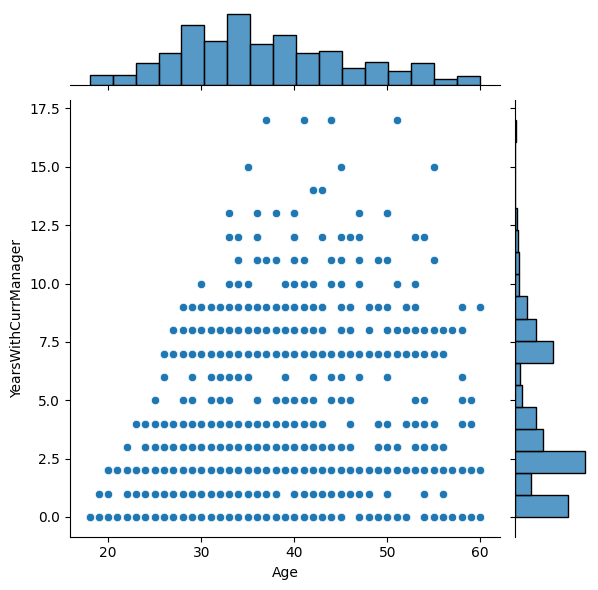

"\nWe don't observe any significant or meaningful differences.\nHowever, an apparent trend is noticeable: \nindividuals aged around 30 to 40 tend to have more work experience with their current boss,\nwhile those younger than 30 tend to have less experience due to their age.\nAdditionally, individuals aged over 40 exhibit a more varied distribution;\nsome have extensive experience while others have shorter experience periods.\n"

In [13]:
sns.jointplot(x='Age', y='YearsWithCurrManager', data=DF, kind='scatter')
plt.show()

"""
We don't observe any significant or meaningful differences.
However, an apparent trend is noticeable: 
individuals aged around 30 to 40 tend to have more work experience with their current boss,
while those younger than 30 tend to have less experience due to their age.
Additionally, individuals aged over 40 exhibit a more varied distribution;
some have extensive experience while others have shorter experience periods.
"""

Compare the average `JobSatisfaction` for employees whose `JobRole` is `Research Scientist`, `Human Resources`, `Manager`, or `Research Director` using a plot.  **(P1-8: 2 points)**

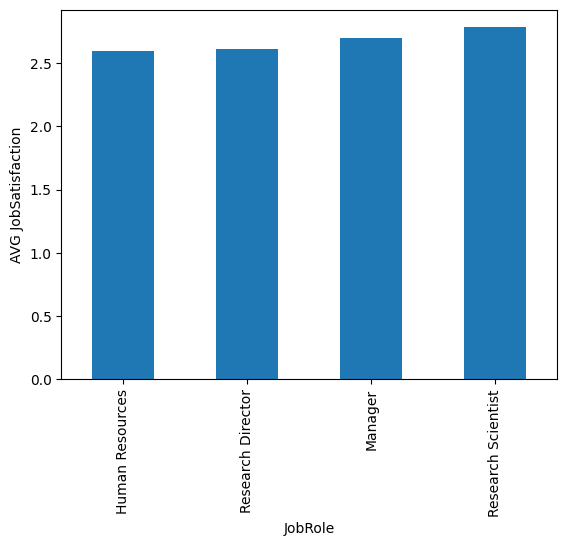

In [14]:
filtered_DF = DF[DF['JobRole'].isin(['Research Scientist', 'Human Resources', 'Manager', 'Research Director'])]

Msatisfaction_by_role =  filtered_DF.groupby('JobRole')['JobSatisfaction'].mean().sort_values()

Msatisfaction_by_role.plot(kind='bar')
plt.ylabel('AVG JobSatisfaction')
plt.show()

Plot the average `MonthlyIncome` against the `YearsAtCompany`. **(P1-9: 1 point)**

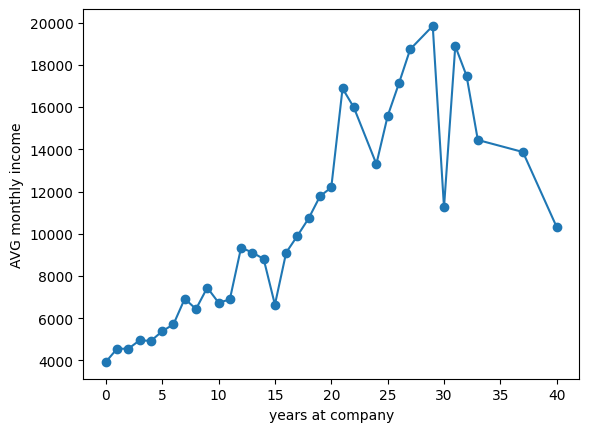

In [15]:
Mincome_by_years = DF.groupby('YearsAtCompany')['MonthlyIncome'].mean()

plt.plot(Mincome_by_years.index, Mincome_by_years.values, marker='o')
plt.xlabel('years at company')
plt.ylabel('AVG monthly income')
plt.show()

# P2: Pre-processing (9 points)

Label encode all categorical columns and split the data into train and test parts. The training part will further splitted into train and validation parts. **(P2-1: 2.5 points)**

In [16]:
encoders = {}
for i in DF.select_dtypes(exclude=["number"]).columns:
    encoders[i] = LabelEncoder()
    DF[i] = encoders[i].fit_transform(DF[i])
    
DF.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,EBusinessTravel
0,29,0,2,592,1,7,3,1,1883,4,...,2,0,11,2,3,3,2,1,2,1
1,36,0,2,884,2,1,4,1,1585,2,...,1,0,15,5,3,1,0,0,0,1
2,34,0,2,1326,2,3,3,4,1478,4,...,4,0,15,2,3,13,9,3,12,1
3,27,0,2,954,2,9,3,2,1965,4,...,1,0,7,5,3,7,7,0,7,1
4,32,0,2,929,2,10,3,2,722,4,...,4,0,10,2,2,10,7,0,8,1


In [17]:
train, TV = train_test_split(DF, test_size=0.2)

In [18]:
print("Xy train : " ,train.shape)
print("Xy test/validation : " ,TV.shape)

Xy train :  (881, 33)
Xy test/validation :  (221, 33)


Further split the test dataframe into validation and test dataframes. **(P2-2: 0.5 point)**

In [19]:
test, validation = train_test_split(TV, test_size=0.5)

print("Xy train : " ,test.shape)
print("Xy validation : " ,validation.shape)

Xy train :  (110, 33)
Xy validation :  (111, 33)


Split the test and validation dataframe into feature and label part, Attrition columns is the target columns and rest of the columns should be treated as features. **(P2-3: 1 point)**

In [20]:
X_val = validation.drop('Attrition', axis=1)
y_val = validation['Attrition']

X_test = test.drop('Attrition', axis=1)
y_test = test['Attrition']

check if the training dataset is label balanced. **(P2-4: 2 points)**

In [21]:
print("percentage : \n", train['Attrition'].value_counts(normalize=True) * 100)

print("\n\nits clear that its not balanced")

percentage : 
 Attrition
0    82.746879
1    17.253121
Name: proportion, dtype: float64


its clear that its not balanced


Balance the training dataset by oversampling the class with less samples. **(P2-5: 2 points)**

Don't know oversampling? Read [this link](https://deeptip.ir/oversampling-and-undersampling-in-python/) (5 minutes)

In [22]:
"""
couldnt open the given link so i looked up this link :
https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

"""
from imblearn.over_sampling import RandomOverSampler

R = RandomOverSampler()
X_train, y_train = R.fit_resample(train.drop('Attrition', axis=1), train['Attrition'])

In [23]:
print("percentage : \n", y_train.value_counts(normalize=True) * 100)

print("\n\nnow we are dealing with a balanced train")

percentage : 
 Attrition
0    50.0
1    50.0
Name: proportion, dtype: float64


now we are dealing with a balanced train


Split the training dataframe into feature and target columns. **(P2-6: 1 point)**

In [24]:
X_train = X_train
y_train = y_train

# P3: Decision tree from scratch (20 points)
Don't know Decision Tree? Read [this link](https://betterdatascience.com/mml-decision-trees/) (25 minutes).

Watch an introduction to Decision Trees [here](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&list=PLblh5JKOoLUIE96dI3U7oxHaCAbZgfhHk) (10 minutes).

Implement decision tree based on the given functions. **(P3-1: 15 points)**

The given functions are not mandatory, you can add or remove any functions if needed.

In [25]:
class DecisionTree:

    def __init__(self, max_depth=None, max_features=None):
        self.max_depth = max_depth
        self.max_features = max_features
        self.tree = {}

    def _compute_entropy(self, y):
        classes, counts = np.unique(y, return_counts=True)
        return -np.sum(counts / len(y) * np.log2(counts / len(y)))

    def _split_data(self, X, y, feature_index, threshold):
        left_mask = X[:, feature_index] <= threshold
        right_mask = X[:, feature_index] > threshold
        return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

    def _find_best_split(self, X, y):
        best_feature_index, best_threshold, best_entropy = None, None, float('inf')
        for feature_index in range(X.shape[1]):
            for threshold in np.unique(X[:, feature_index]):
                left_data, right_data, left_labels, right_labels = self._split_data(X, y, feature_index, threshold)
                if len(left_data) == 0 or len(right_data) == 0: continue
                total_entropy = len(left_labels) / len(y) * self._compute_entropy(left_labels) + len(right_labels) / len(y) * self._compute_entropy(right_labels)
                if total_entropy < best_entropy: best_feature_index, best_threshold, best_entropy = feature_index, threshold, total_entropy
        return best_feature_index, best_threshold

    def _build_tree(self, X, y, depth):
        if depth == 0 or len(np.unique(y)) == 1: return np.bincount(y).argmax()
        best_feature_index, best_threshold = self._find_best_split(X, y)
        if best_feature_index is None: return np.bincount(y).argmax()
        left_data, right_data, left_labels, right_labels = self._split_data(X, y, best_feature_index, best_threshold)
        if len(left_data) == 0 or len(right_data) == 0: return np.bincount(y).argmax()        
        left_subtree ,right_subtree = self._build_tree(left_data, left_labels, depth - 1) , self._build_tree(right_data, right_labels, depth - 1)
        res = dict()
        res["feature_index"], res["threshold"], res["left"], res["right"] = best_feature_index, best_threshold, left_subtree ,right_subtree
        return res

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, self.max_depth)

    def _predict_sample(self, x, tree):
        if not isinstance(tree, dict): return tree
        feature_index, threshold = tree['feature_index'], tree['threshold']
        if x[feature_index] > threshold:
            return self._predict_sample(x, tree['right'])
        return self._predict_sample(x, tree['left'])

    def predict(self, X):
        result = []
        for x in X: 
            result.append(self._predict_sample(x, self.tree))
        return np.array(result)

Define the model and train it. **(P3-2: 1 point)**

In [26]:
customDT = DecisionTree(max_depth = 3)  
customDT.fit(X_train.values, y_train)

Predict the y_train and y_val values. **(P3-3: 1 point)**

In [27]:
y_train_pred = customDT.predict(X_train.values)
y_val_pred = customDT.predict(X_val.values)

In [28]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_train_pred)}, {accuracy_score(y_val, y_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_train_pred)}, {recall_score(y_val, y_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_train_pred)}, {f1_score(y_val, y_val_pred)}')

Train and validation accuracy are: 0.7661179698216736, 0.7387387387387387
Train and validation recall are: 0.6776406035665294, 0.47619047619047616
Train and validation f1 are: 0.7434161023325809, 0.40816326530612246


Visulize (y_train, y_train_pred) using Heatmap **(P3-4: 1.5 points)**

<Axes: >

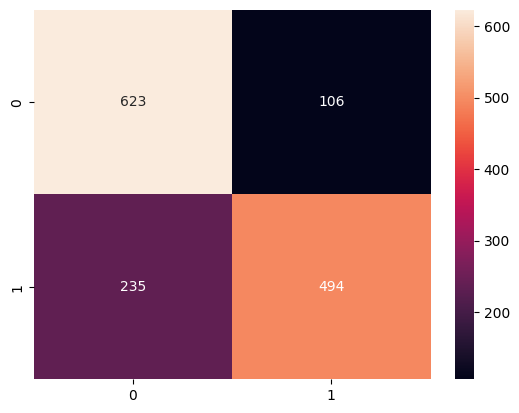

In [29]:
# src: https://www.geeksforgeeks.org/seaborn-heatmap-a-comprehensive-guide/ (6 minutes)
# src: https://blog.faradars.org/confusion-matrix-from-zero-to-hero/ (5 minutes)

CM = confusion_matrix(y_train, y_train_pred)
sns.heatmap(CM, annot=True, fmt='d')

Visulize (y_val, y_val_pred) using Heatmap **(P3-5: 1.5 points)**

<Axes: >

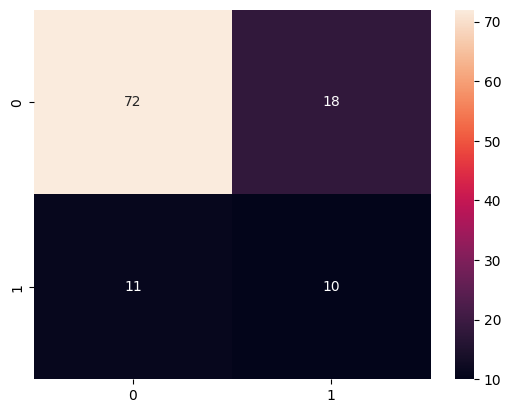

In [30]:
CM = confusion_matrix(y_val, y_val_pred)
sns.heatmap(CM, annot=True, fmt='d')

# P4: Random forest from scratch (20 points)
Don't know Random Forest? Read [this link](https://quera.org/blog/random-forest-algorithm/) (15 minutes).

Implement Random Forest based on the given functions. **(P4-1: 15 points)**

The given functions are not mandatory, you can add or remove any functions if needed.

In [31]:
class RandomForest:
    def __init__(self, num_trees=10, max_depth=None, random_state=None, max_features=None):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.random_state = random_state
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        num_samples ,num_features = X.shape
        for i in range(self.num_trees):
            indices = np.random.choice(num_samples, num_samples, replace = True)
            tree = DecisionTree(max_depth = self.max_depth, max_features = self.max_features)
            if self.max_features:
                feature_indices = np.random.choice(num_features, self.max_features, replace=False)
                tree.fit(X[indices][:, feature_indices], y[indices])
            else:
                tree.fit(X[indices], y[indices])
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.trees)))
        for i, tree in enumerate(self.trees):
            predictions[:, i] = np.round(tree.predict(X)).astype(int)
        return np.array([np.bincount(row.astype(int)).argmax() for row in predictions])

Define the model and train it. **(P4-2: 1 point)**

In [32]:
customRF = RandomForest(num_trees=20, max_depth=5)
customRF.fit(X_train.values, y_train)

Predict the y_train and y_val values. **(P4-3: 1 point)**

In [33]:
y_train_pred = customRF.predict(X_train.values)
y_val_pred = customRF.predict(X_val.values)

In [34]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_train_pred)} ,{accuracy_score(y_val, y_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_train_pred)} ,{recall_score(y_val, y_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_train_pred)} ,{f1_score(y_val, y_val_pred)}')

Train and validation accuracy are: 0.8786008230452675 ,0.7567567567567568
Train and validation recall are: 0.8436213991769548 ,0.5238095238095238
Train and validation f1 are: 0.8742004264392325 ,0.4489795918367347


Visulize (y_train, y_train_pred) using Heatmap **(P4-4: 1.5 points)**

<Axes: >

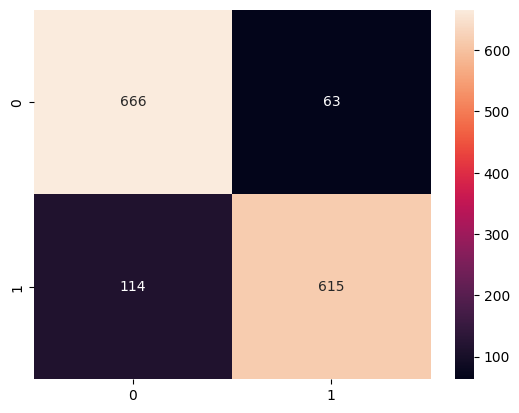

In [35]:
CM = confusion_matrix(y_train, y_train_pred)
sns.heatmap(CM, annot=True, fmt='d')

Visulize (y_val, y_val_pred) using Heatmap **(P4-5: 1.5 points)**

<Axes: >

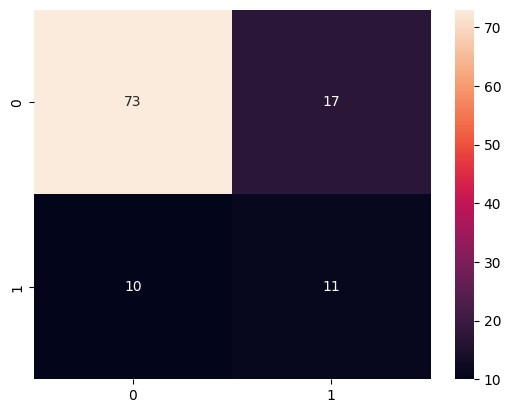

In [36]:
CM = confusion_matrix(y_val, y_val_pred)
sns.heatmap(CM, annot=True, fmt='d')

# P5: Decision Tree (10 points)

Fit the data to a decision tree (of sklearn) with maximum depth of 2. **(P5-1: 2 points)**

In [37]:
SKDT = DecisionTreeClassifier(max_depth=2)
SKDT.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

Plot the fitted decision tree. **(P5-2: 2 points)**

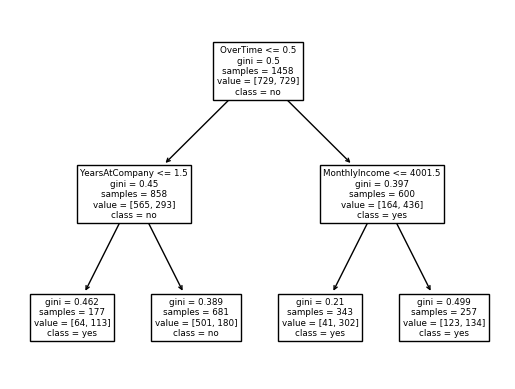

In [38]:
plot_tree(SKDT ,class_names = ["no" ,"yes"] ,feature_names = X_train.columns)
plt.show()

Make predictions on training and validation set and calculate accuracy, recall and f1_score on them. **(P5-3: 1 point)**

In [39]:
y_train_pred = SKDT.predict(X_train)
y_val_pred = SKDT.predict(X_val)

In [40]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_train_pred)} ,{accuracy_score(y_val, y_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_train_pred)} ,{recall_score(y_val, y_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_train_pred)} ,{f1_score(y_val, y_val_pred)}')

Train and validation accuracy are: 0.720164609053498 ,0.5675675675675675
Train and validation recall are: 0.7530864197530864 ,0.5238095238095238
Train and validation f1 are: 0.7290836653386454 ,0.3142857142857143


Plot the confusion matrices for the training and validation datasets. **(P5-4: 2 points)**

<Axes: >

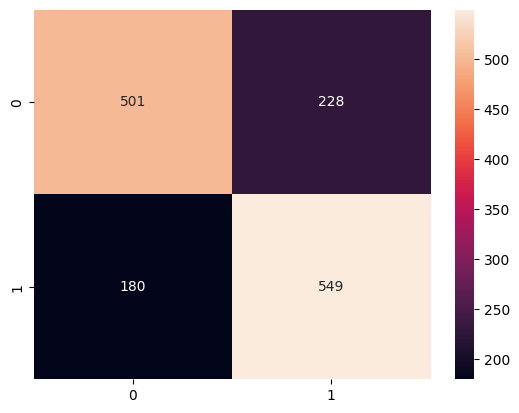

In [41]:
CM = confusion_matrix(y_train, y_train_pred)
sns.heatmap(CM, annot=True, fmt='d')

<Axes: >

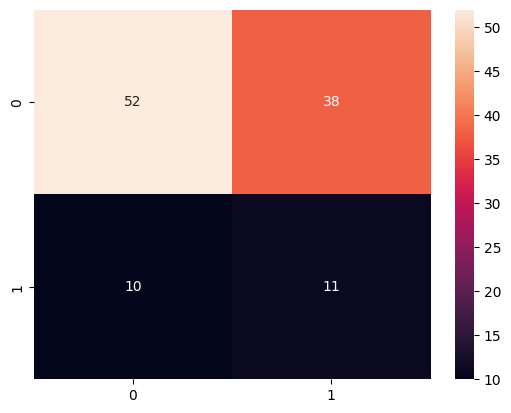

In [42]:
CM = confusion_matrix(y_val, y_val_pred)
sns.heatmap(CM, annot=True, fmt='d')

Experiment with different depth trees and plot the f1_score associated with each depth on training and valication datasets. **(P5-5: 3 points)**

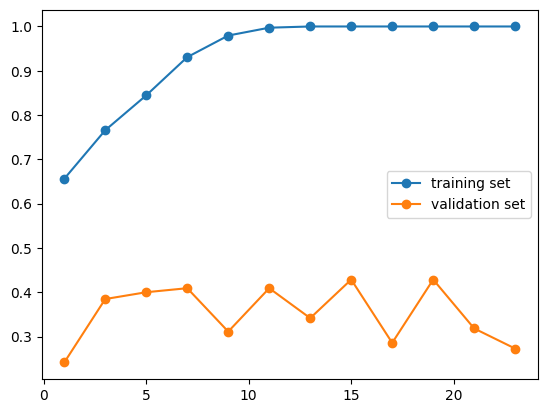

In [43]:
D = [i for i in range(1 ,24 ,2)]

trainScores ,valScores = [] ,[]

for i in D : 
    SKDT = DecisionTreeClassifier(max_depth = i)
    SKDT.fit(X_train ,y_train)
    y_train_pred = SKDT.predict(X_train)
    y_val_pred = SKDT.predict(X_val)
    trainScores.append(f1_score(y_train ,y_train_pred))
    valScores.append(f1_score(y_val ,y_val_pred))

plt.plot(D ,trainScores ,label='training set' ,marker = 'o')
plt.plot(D ,valScores ,label='validation set' ,marker = 'o')
plt.legend()
plt.show()

# P6: Random Forest (7 points)

Fit the training data to a random forest (of sklearn). **(P6-1: 2 points)**

In [44]:
SKRF = RandomForestClassifier(n_estimators=100, max_depth = 6)
SKRF.fit(X_train, y_train)

RandomForestClassifier(max_depth=6)

Plot the feature importances using a bar plot. **(P6-2: 2 points)**

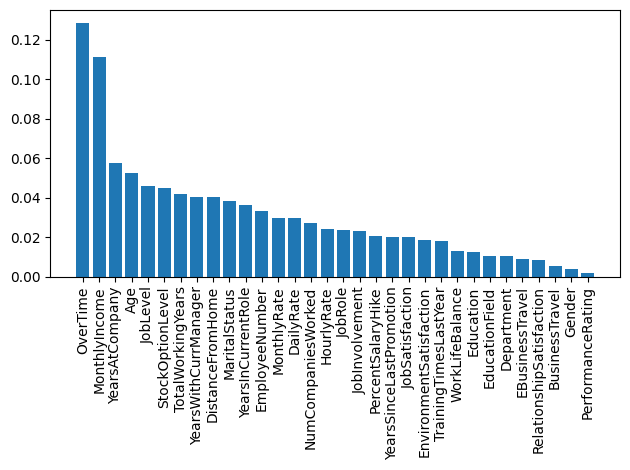

In [45]:
importances = SKRF.feature_importances_
Sindices = np.argsort(importances)[::-1]
Sfeature_names = [X_train.columns[i] for i in Sindices]

plt.bar(range(X_train.shape[1]), importances[Sindices], align='center')
plt.xticks(range(X_train.shape[1]), Sfeature_names, rotation=90)
plt.tight_layout()
plt.show()

Make predictions using the model and print the accuracy, recall, f1_score and plot the confusion matrices for training and validation data. **(P6-3: 1 point)**

In [46]:
y_train_pred = SKRF.predict(X_train)
y_val_pred = SKRF.predict(X_val)

In [47]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_train_pred)} ,{accuracy_score(y_val, y_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_train_pred)} ,{recall_score(y_val, y_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_train_pred)} ,{f1_score(y_val, y_val_pred)}')

Train and validation accuracy are: 0.9430727023319616 ,0.8018018018018018
Train and validation recall are: 0.9314128943758574 ,0.38095238095238093
Train and validation f1 are: 0.9424011103400417 ,0.42105263157894735


Plot the confusion matrices for the training and validation datasets. **(P6-4: 2 points)**

<Axes: >

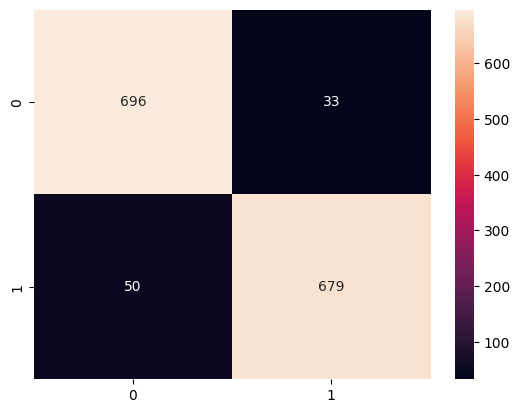

In [48]:
CM = confusion_matrix(y_train, y_train_pred)
sns.heatmap(CM, annot=True, fmt='d')

<Axes: >

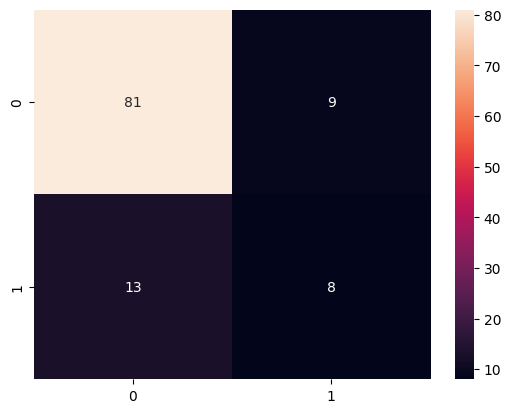

In [49]:
CM = confusion_matrix(y_val, y_val_pred)
sns.heatmap(CM, annot=True, fmt='d')

# P7: Gradient Boosted Decision Trees (5 points)
Don't know GBD Tree? Follow [this link](https://www.machinelearningplus.com/machine-learning/an-introduction-to-gradient-boosting-decision-trees/) (+30 minutes).

Fit a gradient boosted decision tree(e.g. catboost, lightgbm, xgboost). **(P7-1: 2 points)**

Using the catboost library is recommended

In [50]:
CBC = CatBoostClassifier()
CBC.fit(X_train, y_train)

Learning rate set to 0.012102
0:	learn: 0.6876144	total: 56.6ms	remaining: 56.5s
1:	learn: 0.6822054	total: 59.1ms	remaining: 29.5s
2:	learn: 0.6757909	total: 61.6ms	remaining: 20.5s
3:	learn: 0.6694107	total: 63.6ms	remaining: 15.8s
4:	learn: 0.6637153	total: 65.7ms	remaining: 13.1s
5:	learn: 0.6573517	total: 67.6ms	remaining: 11.2s
6:	learn: 0.6518850	total: 69.6ms	remaining: 9.88s
7:	learn: 0.6462224	total: 71.7ms	remaining: 8.9s
8:	learn: 0.6403746	total: 73.9ms	remaining: 8.14s
9:	learn: 0.6353566	total: 75.9ms	remaining: 7.51s
10:	learn: 0.6309829	total: 77.9ms	remaining: 7.01s
11:	learn: 0.6249866	total: 80ms	remaining: 6.59s
12:	learn: 0.6199559	total: 82.1ms	remaining: 6.23s
13:	learn: 0.6153236	total: 84.2ms	remaining: 5.93s
14:	learn: 0.6102921	total: 86.3ms	remaining: 5.67s
15:	learn: 0.6054913	total: 88.4ms	remaining: 5.44s
16:	learn: 0.6001539	total: 90.5ms	remaining: 5.23s
17:	learn: 0.5946300	total: 92.5ms	remaining: 5.05s
18:	learn: 0.5906225	total: 94.6ms	remaining: 4

Make predictions using the model and print the accuracy, recall, f1_score and plot the confusion matrices for training and validation data. **(P7-2: 1 point)**

In [51]:
y_train_pred = CBC.predict(X_train)
y_val_pred = CBC.predict(X_val)

In [52]:
print(f'Train and test accuracy are: {accuracy_score(y_train, y_train_pred)} ,{accuracy_score(y_val, y_val_pred)}')

print(f'Train and test recall are: {recall_score(y_train, y_train_pred)} ,{recall_score(y_val, y_val_pred)}')

print(f'Train and test f1 are: {f1_score(y_train, y_train_pred)} ,{f1_score(y_val, y_val_pred)}')

Train and test accuracy are: 1.0 ,0.8018018018018018
Train and test recall are: 1.0 ,0.23809523809523808
Train and test f1 are: 1.0 ,0.31249999999999994


Plot the confusion matrices for the training and validation datasets. **(P7-3: 2 points)**

<Axes: >

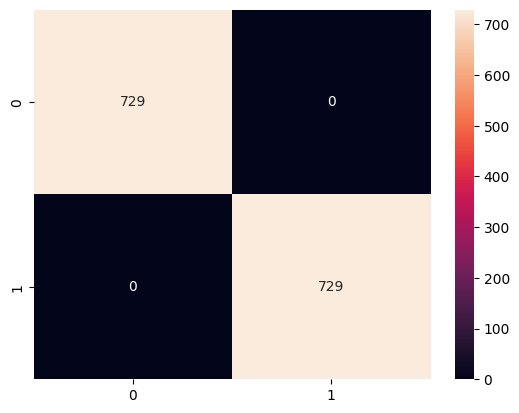

In [53]:
CM = confusion_matrix(y_train, y_train_pred)
sns.heatmap(CM, annot=True, fmt='d')

<Axes: >

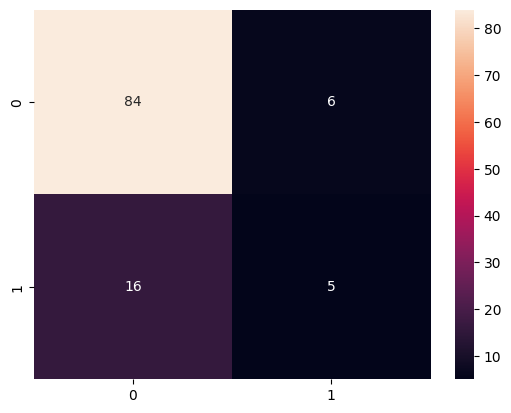

In [54]:
CM = confusion_matrix(y_val, y_val_pred)
sns.heatmap(CM, annot=True, fmt='d')

# P8: Tuning parameters using optuna? (12 points)

There are many tunable parameters in Gradient boosted decision trees tuning all of them using grid search is almost impossible. There is no other choice for tuing hyperparameters unless you assume some models on behaviour of models under different hyperparameter choices e.g. the follow a gaussian process. Use the optuna library to tune the hyperparameters of gradient boosted decision tree. Report the results as in the previous parts. **(P8-1: 10 points)**

Do you want to get familiar more with it? Follow [this link](https://datagy.io/python-optuna/) (+40 minutes)

Do you know the difference between parameters and hyperparameters? If no, you can find more [here](https://virgool.io/@maryam.hasanali/%D9%87%D8%A7%DB%8C%D9%BE%D8%B1%D9%BE%D8%A7%D8%B1%D8%A7%D9%85%D8%AA%D8%B1%D9%87%D8%A7%DB%8C-%D8%AF%D8%B1-%DB%8C%DA%A9-%D9%85%D8%AF%D9%84-%DB%8C%D8%A7%D8%AF%DA%AF%DB%8C%D8%B1%DB%8C-%D9%85%D8%A7%D8%B4%DB%8C%D9%86-%DA%86%DB%8C%D8%B3%D8%AA-%D9%88-%DA%86%DA%AF%D9%88%D9%86%D9%87-%D8%A2%D9%86-%D8%B1%D8%A7-%D8%AA%D9%86%D8%B8%DB%8C%D9%85-%DA%A9%D9%86%DB%8C%D9%85-o8zgjoouhwen) (3 minutes).

In [55]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

def objective(trial):
    params = { 'iterations': trial.suggest_int('iterations', 80, 1200),
            'depth': trial.suggest_int('depth', 3, 12),
            'random_strength': trial.suggest_float('random_strength', 0.0, 100.0),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),

    }

    catboost_model = CatBoostClassifier(**params, verbose=False)
    catboost_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)
    val_preds = catboost_model.predict(X_val)
    f1 = f1_score(y_val, val_preds)
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
trial = study.best_trial
print(trial.params)


[I 2024-01-07 10:15:46,249] A new study created in memory with name: no-name-06fc37c8-7532-4f88-b94e-dd4a688602b1
[I 2024-01-07 10:15:47,276] Trial 0 finished with value: 0.4390243902439024 and parameters: {'iterations': 383, 'depth': 6, 'random_strength': 72.39686447197738, 'learning_rate': 0.003694737156646926, 'bagging_temperature': 1.2851704419986587, 'l2_leaf_reg': 0.33658920612470994}. Best is trial 0 with value: 0.4390243902439024.
[I 2024-01-07 10:15:48,391] Trial 1 finished with value: 0.4615384615384615 and parameters: {'iterations': 740, 'depth': 3, 'random_strength': 46.64751238584225, 'learning_rate': 0.0013417832165917266, 'bagging_temperature': 7.478709845394935, 'l2_leaf_reg': 1.9751561873992092}. Best is trial 1 with value: 0.4615384615384615.
[I 2024-01-07 10:15:49,333] Trial 2 finished with value: 0.3888888888888889 and parameters: {'iterations': 324, 'depth': 6, 'random_strength': 44.10484113309657, 'learning_rate': 0.0345037591789964, 'bagging_temperature': 8.22471

{'iterations': 680, 'depth': 3, 'random_strength': 46.347253514709294, 'learning_rate': 0.18177958455445686, 'bagging_temperature': 0.5194405913798994, 'l2_leaf_reg': 0.001419387777424032}


In [56]:
CBC_ = CatBoostClassifier(**trial.params, verbose=False)
CBC_.fit(X_train, y_train)

y_train_pred = CBC_.predict(X_train)
y_val_pred = CBC_.predict(X_val)

print(f'Train and test accuracy are: {accuracy_score(y_train, y_train_pred)} ,{accuracy_score(y_val, y_val_pred)}')

print(f'Train and test recall are: {recall_score(y_train, y_train_pred)} ,{recall_score(y_val, y_val_pred)}')

print(f'Train and test f1 are: {f1_score(y_train, y_train_pred)} ,{f1_score(y_val, y_val_pred)}')

Train and test accuracy are: 1.0 ,0.8108108108108109
Train and test recall are: 1.0 ,0.2857142857142857
Train and test f1 are: 1.0 ,0.36363636363636365


Plot the confusion matrices for the training and validation datasets. **(P8-2: 2 points)**

<Axes: >

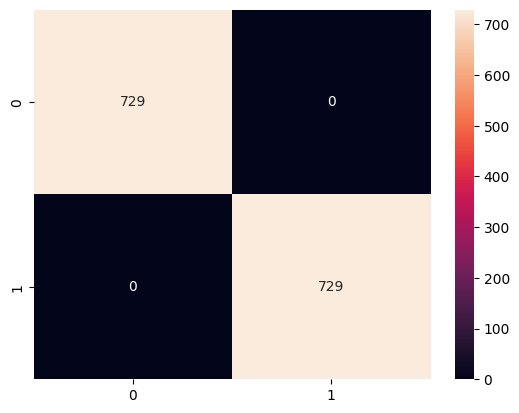

In [57]:
CM = confusion_matrix(y_train, y_train_pred)
sns.heatmap(CM, annot=True, fmt='d')

<Axes: >

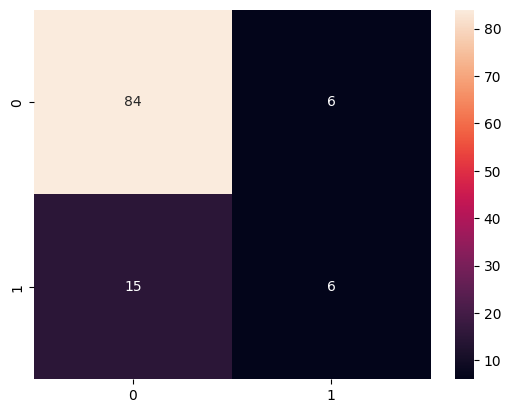

In [58]:
CM = confusion_matrix(y_val, y_val_pred)
sns.heatmap(CM, annot=True, fmt='d')

# P9: Performance on testing data (4 points)

call the model on test data. **(P9-1: 1 point)**

In [59]:
y_test_pred = CBC_.predict(X_test)

evaluate your model on the testing data using f1_score. **(P9-2: 1 point)**

In [60]:
print("F1 score on test : " ,f1_score(y_test ,y_test_pred))

F1 score on test :  0.5806451612903225


What is the origin of loosing performance on the test set? Answer briefly here. **(P9-3: 1 point)**

Some reasons for the decrease in performance on test data may be :</br>

* Overfitting the training data and obtaining learning parameters specific to the training data, thereby limiting generalization ability.</br>
*Randomness: Machine learning algorithms often encompass a level of randomness that can occasionally lead to a performance drop.</br>
*Hyperparameters: We might have chosen a suboptimal range for hyperparameters, reducing their effectiveness

Plot the heatmap of the confusion matrix here. **(P9-4: 1 point)**

<Axes: >

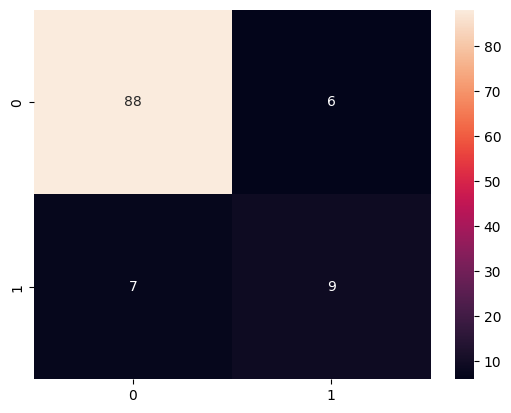

In [61]:
CM = confusion_matrix(y_test, y_test_pred)
sns.heatmap(CM, annot=True, fmt='d')